In [14]:
## imports
import sys
import os
import numpy as np
import xarray as xr
import cmocean
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import cartopy
import cartopy.crs as ccrs
from mpl_toolkits.axes_grid1.axes_divider import make_axes_locatable
from matplotlib import gridspec
import cartopy.mpl.ticker as cticker
import scipy
import scipy.stats
import xesmf as xe

from defs import mmm, lon180

In [15]:
folder = 'Data_processed/'
modellist =  ['GISS2.1G', 'EC-Earth3-LR', 'CCSM4-UoT', 'CCSM4-Utr','CCSM4', 'CESM1.2', 'CESM2', 'IPSL-CM5A', 'IPSL-CM5A2','IPSL-CM6A','MIROC4m','COSMOS', 'HadCM3', 'NorESM1-F','HadGEM3']

## Figure 1

In [16]:
dsE280t = xr.open_dataset(folder+'MMM_ensemble/E280/thetao_1x1_100yr.nc')
dsEoi400t = xr.open_dataset(folder+'MMM_ensemble/Eoi400/thetao_1x1_100yr.nc')
dsgrid = xr.open_dataset(folder+'1x1grid.nc')

area = dsgrid.area
sstE280 = mmm(dsE280t.thetao[:,0])
sstEoi400 = mmm(dsEoi400t.thetao[:,0])

In [17]:
#Find SST anomalies and SO amplification
anom = (dsEoi400t.thetao[:,0]-dsE280t.thetao[:,0]) #SST anomaly

glob = (anom).weighted(area).mean(dim=['lat','lon']).mean(dim='model').values #Global average SST anomaly
so = (anom).where(anom.lat<=-45).weighted(area).mean(dim=['lat','lon']).mean(dim='model').values #SO average SST anomaly

print('Global mean SST anomaly is %.1f degC' %glob)
print('Southern Ocean mean SST anomaly is %.1f degC' %so)
print('Southern Ocean SST amplification index is %.1f' %(so/glob))

#Compute average SO SST anomaly for each model
ssta = (anom).where(anom.lat<=-45).weighted(area).mean(dim=['lat','lon']) #SO average SST anomaly

Global mean SST anomaly is 2.4 degC
Southern Ocean mean SST anomaly is 2.8 degC
Southern Ocean SST amplification index is 1.2


In [18]:
dsE280 = xr.open_dataset(folder+'MMM_ensemble/E280/SI_100yr.nc')
dsEoi400 = xr.open_dataset(folder+'MMM_ensemble/Eoi400/SI_100yr.nc')

siE280 = mmm(dsE280.si_mean)
siEoi400 = mmm(dsEoi400.si_mean)


#Compute SH sea-ice area anomaly for each model
E280sia = ((dsE280.si_mean.where(dsE280.lat<0))/100*area).sum(dim=['lat','lon'])
Eoi400sia = (((dsEoi400.si_mean.where(dsEoi400.lat<0)).where(dsE280.si_mean>=0))/100*area).sum(dim=['lat','lon'])

sia = (Eoi400sia-E280sia)/E280sia*100

/var/folders/f4/c_hqzq2n50q925l69wbn3_dw0000gn/T/ipykernel_61813/4079071782.py:6: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap0 = plt.cm.get_cmap("cmo.thermal",6).copy()
/var/folders/f4/c_hqzq2n50q925l69wbn3_dw0000gn/T/ipykernel_61813/4079071782.py:9: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap1 = plt.cm.get_cmap("cmo.ice").copy()
/var/folders/f4/c_hqzq2n50q925l69wbn3_dw0000gn/T/ipykernel_61813/4079071782.py:12: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap2 

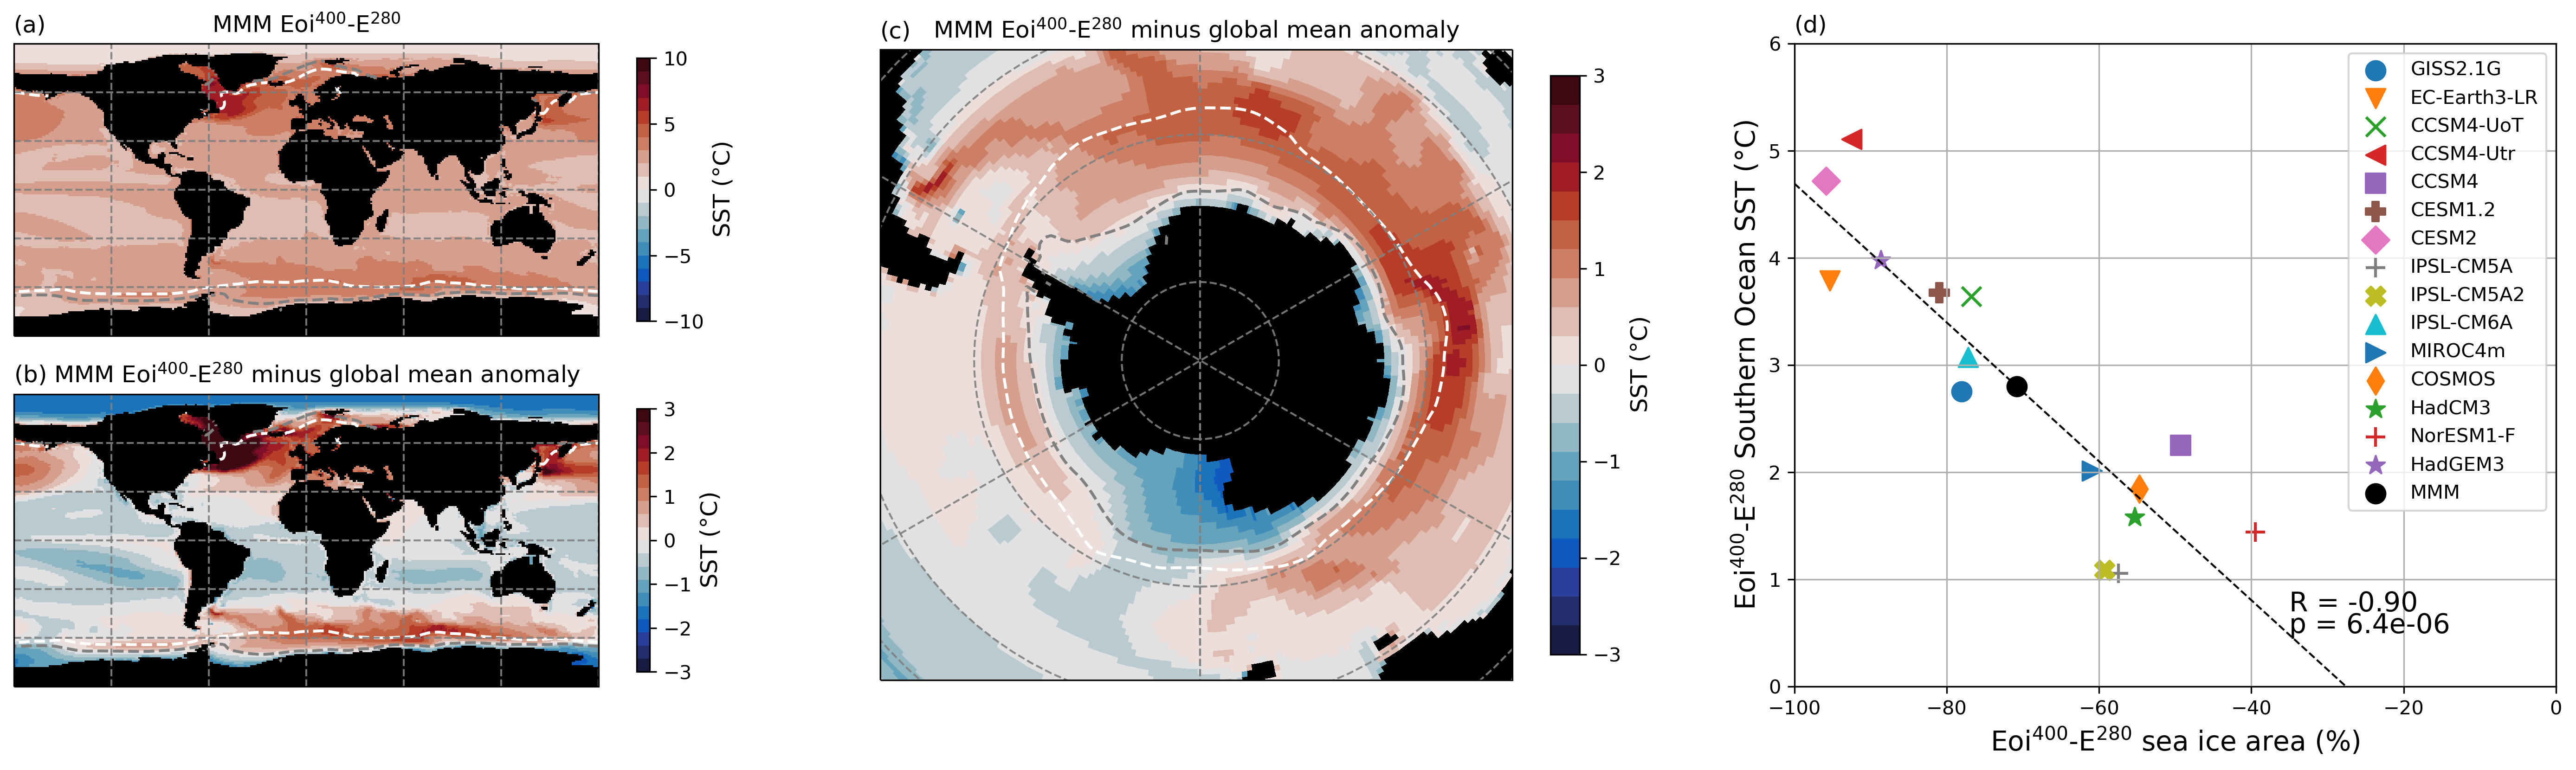

In [19]:
## creeer je figuur:
fig = plt.figure(figsize=(24,6), dpi=300)
## creeer je assen. Ik voeg hier de projectie 'plate carree' toe, Cartopy heeft verschillende, bijv EqualEarth
proj = ccrs.Orthographic(central_longitude=0.0, central_latitude=-90.0)

cmap0 = plt.cm.get_cmap("cmo.thermal",6).copy()
cmap0.set_under('lightgrey')

cmap1 = plt.cm.get_cmap("cmo.ice").copy()
cmap1.set_under('lightgrey')

cmap2 = plt.cm.get_cmap("cmo.balance",20).copy()
cmap2.set_under('black')

iceline = 15
spec = fig.add_gridspec(2, 3)

ax = fig.add_subplot(spec[0, 0:1], projection=ccrs.PlateCarree())
im=ax.pcolormesh(sstE280.lon,sstE280.lat,(sstEoi400-sstE280).fillna(-200), transform=ccrs.PlateCarree(), cmap=cmap2, vmin = -10, vmax = 10)
ax.contour(siE280.lon,siE280.lat,siEoi400, colors=['grey','grey'], linestyles = ['dashed'], levels=[-1000,iceline], alpha=1, zorder=1,transform=ccrs.PlateCarree())
ax.contour(siE280.lon,siE280.lat,siE280, colors=['w','w'], linestyles = ['dashed'], levels=[-1000,iceline], alpha=1, zorder=1,transform=ccrs.PlateCarree())
ax.set_extent([-180, 180, -90,90], crs=ccrs.PlateCarree())
cb = fig.colorbar(im, ax = ax, orientation='vertical', fraction = 0.12, shrink = 0.9)
cb.set_label(label = 'SST ($\degree$C)', fontsize=12)
ax.set_title(r'MMM Eoi$^{400}$-E$^{280}$', loc='center')
ax.set_title(r'(a)', loc='left')
lat_lines = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=False, linewidth=1, color='gray', alpha=0.9, linestyle='--')


dsst = (sstEoi400-sstE280)
ax = fig.add_subplot(spec[1, 0:1], projection=ccrs.PlateCarree())
im=ax.pcolormesh(sstE280.lon,sstE280.lat,(dsst-dsst.weighted(area).mean()).fillna(-200), transform=ccrs.PlateCarree(), cmap=cmap2, vmin = -3, vmax = 3)
ax.contour(siE280.lon,siE280.lat,siEoi400, colors=['grey','grey'], linestyles = ['dashed'], levels=[-1000,iceline], alpha=1, zorder=1,transform=ccrs.PlateCarree())
ax.contour(siE280.lon,siE280.lat,siE280, colors=['w','w'], linestyles = ['dashed'], levels=[-1000,iceline], alpha=1, zorder=1,transform=ccrs.PlateCarree())
ax.set_extent([-180, 180, -90,90], crs=ccrs.PlateCarree())
cb = fig.colorbar(im, ax = ax, orientation='vertical', fraction = 0.12, shrink = 0.9)
cb.set_label(label = 'SST ($\degree$C)', fontsize=12)
ax.set_title(r'(b) MMM Eoi$^{400}$-E$^{280}$ minus global mean anomaly', loc='left')
lat_lines = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=False, linewidth=1, color='gray', alpha=0.9, linestyle='--')

ax = fig.add_subplot(spec[0:2, 1:2], projection=proj)
im=ax.pcolormesh(sstE280.lon,sstE280.lat,(dsst-dsst.weighted(area).mean()).fillna(-200), transform=ccrs.PlateCarree(), cmap=cmap2, vmin = -3, vmax = 3)
ax.contour(siE280.lon,siE280.lat,siEoi400, colors=['grey','grey'], linestyles = ['dashed'], levels=[-1000,iceline], alpha=1, zorder=1,transform=ccrs.PlateCarree())
ax.contour(siE280.lon,siE280.lat,siE280, colors=['w','w'], linestyles = ['dashed'], levels=[-1000,iceline], alpha=1, zorder=1,transform=ccrs.PlateCarree())
ax.set_extent([-180, 180, -90,-45], crs=ccrs.PlateCarree())
cb = fig.colorbar(im, ax = ax, orientation='vertical', fraction = 0.12, shrink = 0.9)
cb.set_label(label = 'SST ($\degree$C)', fontsize=12)
ax.set_title(r'MMM Eoi$^{400}$-E$^{280}$ minus global mean anomaly', loc='center')
ax.set_title(r'(c)', loc='left')
lat_lines = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=False, linewidth=1, color='gray', alpha=0.9, linestyle='--')

x = np.arange(-200,10,0.1)

markers = ["o","v","x","<","s","P","D","+","X","^",">","d","*","+","*"]
ax = fig.add_subplot(spec[0:2, 2])

#Perform linear regression between sea-ice area and sst anomaly in SO
p = scipy.stats.linregress(sia, ssta)

for j in range(0,len(modellist)):
    scatter = ax.scatter(sia[j], ssta[j], s=100, c = 'C'+str(j), label=modellist[j], marker=markers[j])
scatter = ax.scatter(np.mean(sia), np.mean(ssta), s=100, c = 'k', label='MMM', marker='o')

ax.plot(x, x*p[0]+p[1], color='black',linewidth =1, linestyle ='--')    
ax.text(-35,0.7,'R = %.2f' %(p[2]), fontsize=14)
ax.text(-35,0.5, 'p = %.1e' %(p[3]), fontsize=14)

ax.set_ylim([0, 6])
ax.set_xlabel('Eoi$^{400}$-E$^{280}$ sea ice area (%)', fontsize=14)
ax.set_xlim([-100, 0])
ax.set_title(r'(d)', loc='left')

ax.legend(loc='upper right', fontsize=10)
ax.grid()

ax.set_ylabel(r'Eoi$^{400}$-E$^{280}$ Southern Ocean SST ($\degree$C)', fontsize=14)
#plt.savefig('Fig1.png', bbox_inches='tight')
plt.show()

## Sea ice concentration compared to observations by Whitehead (2005)

In [20]:
# Concentrations at sites from Whitehead(2005)
# Site 1165 (64.380$\degree$S, 67.219$\degree$E and Site 1167 (67.696$\degree$S, 74.787$\degree$E)

In [21]:
e280s1 = dsE280.si_jja.mean(dim='model').sel(lon = 67.219, method='nearest').sel(lat = -64.380, method='nearest').values
eoi400s1 = dsEoi400.si_jja.mean(dim='model').sel(lon = 67.219, method='nearest').sel(lat = -64.380, method='nearest').values

print('Summer sea ice cover decrease at site 1165 is %.0f %%' %((eoi400s1-e280s1)/e280s1*100))
print('Mid-Pliocene summer sea ice cover at site 1165 is %.0f %%' %eoi400s1)

Summer sea ice cover decrease at site 1165 is -72 %
Mid-Pliocene summer sea ice cover at site 1165 is 25 %


In [22]:
e280s1 = dsE280.si_jja.mean(dim='model').sel(lon = 74.787, method='nearest').sel(lat = -67.696, method='nearest').values
eoi400s1 = dsEoi400.si_jja.mean(dim='model').sel(lon = 74.787, method='nearest').sel(lat = -67.696, method='nearest').values

print('Summer sea ice cover decrease at site 1167 is %.0f %%' %((eoi400s1-e280s1)/e280s1*100))
print('Mid-Pliocene summer sea ice cover at site 1167 is %.0f %%' %eoi400s1)

Summer sea ice cover decrease at site 1167 is -39 %
Mid-Pliocene summer sea ice cover at site 1167 is 55 %


## Sea ice concentration compared to observations: SFig 11

In [23]:
dsobs = xr.open_dataset(folder+'Observations/NSIDCseaice.nc')
dsgrid = xr.open_dataset(folder+'Observations/G02202-cdr-ancillary-sh.nc')

obs_monthly = dsobs.cdr_seaice_conc_monthly[2:12*25+2].groupby('time.month').mean(dim='tdim').where(dsgrid.landmask==0)*100

regridder = xe.Regridder(dsgrid, dsE280t, 'bilinear', periodic = False, ignore_degenerate=True)
obs_monthly_rg = regridder(obs_monthly) #Regridded observations
obs_mean_rg = obs_monthly_rg.mean(dim='month')

In [24]:
#Observations
obs_winter_rg = obs_monthly_rg[5:8].mean(dim='month')
obs_summer_rg = (obs_monthly_rg[11]+2*obs_monthly_rg[0:2].mean(dim='month'))/3
obs_mean_rg = obs_monthly_rg.mean(dim='month')

In [25]:
#Models
mod_winter = mmm(dsE280.si_jja)
mod_summer = mmm(dsE280.si_djf)
mod_mean = mmm(dsE280.si_mean)

/var/folders/f4/c_hqzq2n50q925l69wbn3_dw0000gn/T/ipykernel_61813/3957314095.py:6: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap2 = plt.cm.get_cmap("PuOr",20).copy()


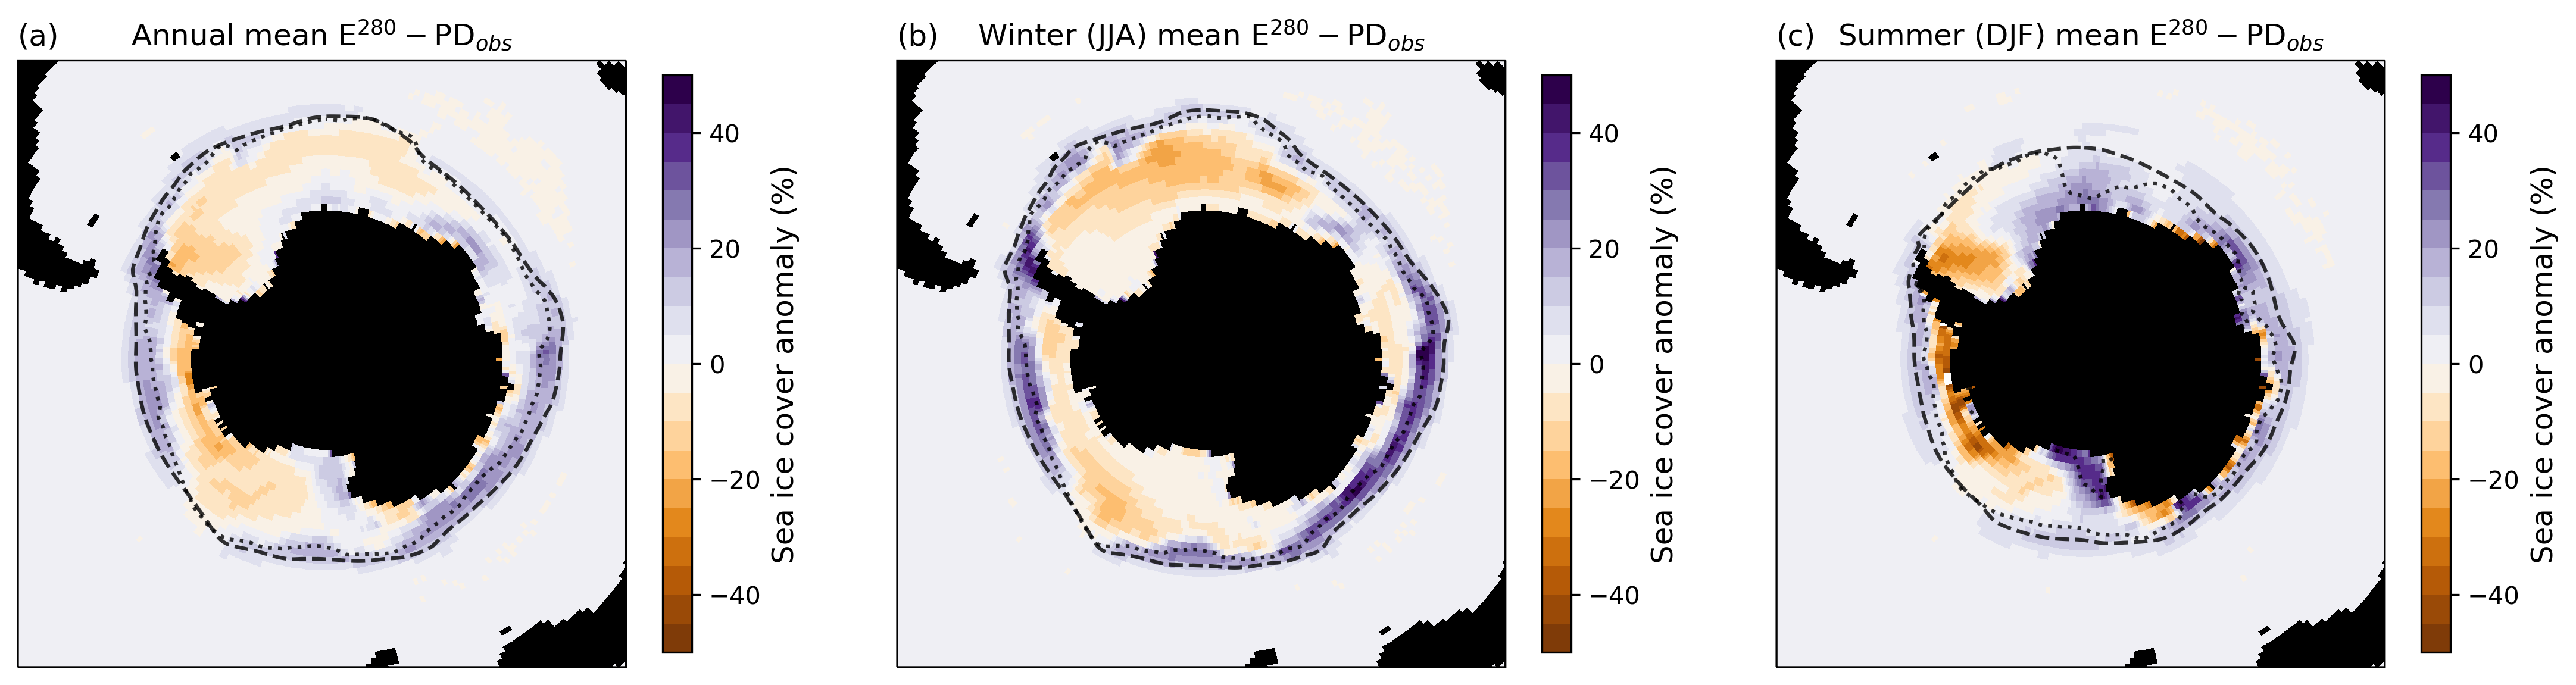

In [26]:
## creeer je figuur:
fig = plt.figure(figsize=(18,6), dpi=300)
## creeer je assen. Ik voeg hier de projectie 'plate carree' toe, Cartopy heeft verschillende, bijv EqualEarth
proj = ccrs.Orthographic(central_longitude=0.0, central_latitude=-90.0)

cmap2 = plt.cm.get_cmap("PuOr",20).copy()
cmap2.set_bad('black')
cmap2.set_under('white')

iceline = 15

ax = fig.add_subplot(131, projection=proj)
im=ax.pcolormesh(dsE280.lon,dsE280.lat,(mod_mean-obs_mean_rg), transform=ccrs.PlateCarree(), cmap=cmap2, vmin = -50, vmax = 50)
ax.contour(dsE280.lon,dsE280.lat,mod_mean, colors=['k','k'], linestyles = ['dashed'], levels=[-1000,iceline], alpha=0.8, zorder=1,transform=ccrs.PlateCarree())
ax.contour(dsE280.lon,dsE280.lat,obs_mean_rg, colors=['k','k'], linestyles = ['dotted'], levels=[-1000,iceline], alpha=0.8, zorder=1,transform=ccrs.PlateCarree())
ax.set_extent([-180, 180, -90,-45], crs=ccrs.PlateCarree())
cb = fig.colorbar(im, ax = ax, orientation='vertical', fraction = 0.12, shrink = 0.7)
cb.set_label(label = 'Sea ice cover anomaly (%)', fontsize=12)
ax.set_title(r'Annual mean E$^{280}-$PD$_{{obs}}$', loc='center')
ax.set_title(r'(a)', loc='left')

ax = fig.add_subplot(132, projection=proj)
im=ax.pcolormesh(dsE280.lon,dsE280.lat,(mod_winter-obs_winter_rg), transform=ccrs.PlateCarree(), cmap=cmap2, vmin = -50, vmax = 50)
ax.contour(dsE280.lon,dsE280.lat,mod_winter, colors=['k','k'], linestyles = ['dashed'], levels=[-1000,iceline], alpha=0.8, zorder=1,transform=ccrs.PlateCarree())
ax.contour(dsE280.lon,dsE280.lat,obs_winter_rg, colors=['k','k'], linestyles = ['dotted'], levels=[-1000,iceline], alpha=0.8, zorder=1,transform=ccrs.PlateCarree())
ax.set_extent([-180, 180, -90,-45], crs=ccrs.PlateCarree())
cb = fig.colorbar(im, ax = ax, orientation='vertical', fraction = 0.12, shrink = 0.7)
cb.set_label(label = 'Sea ice cover anomaly (%)', fontsize=12)
ax.set_title(r'Winter (JJA) mean E$^{280}-$PD$_{{obs}}$', loc='center')
ax.set_title(r'(b)', loc='left')

ax = fig.add_subplot(133, projection=proj)
im=ax.pcolormesh(dsE280.lon,dsE280.lat,(mod_summer-obs_summer_rg), transform=ccrs.PlateCarree(), cmap=cmap2, vmin = -50, vmax = 50)
ax.contour(dsE280.lon,dsE280.lat,mod_summer, colors=['k','k'], linestyles = ['dashed'], levels=[-1000,iceline], alpha=0.8, zorder=1,transform=ccrs.PlateCarree())
ax.contour(dsE280.lon,dsE280.lat,obs_summer_rg, colors=['k','k'], linestyles = ['dotted'], levels=[-1000,iceline], alpha=0.8, zorder=1,transform=ccrs.PlateCarree())
ax.set_extent([-180, 180, -90,-45], crs=ccrs.PlateCarree())
cb = fig.colorbar(im, ax = ax, orientation='vertical', fraction = 0.12, shrink = 0.7)
cb.set_label(label = 'Sea ice cover anomaly (%)', fontsize=12)
ax.set_title(r'Summer (DJF) mean E$^{280}-$PD$_{{obs}}$', loc='center')
ax.set_title(r'(c)', loc='left')

#plt.savefig('SFig11.png', bbox_inches='tight')

plt.show()

In [27]:
obsarea = ((obs_mean_rg/100)*area).sum()/1e6
modarea = ((mod_mean.where(mod_mean.lat<0)/100)*area).sum()/1e6

print('Annual average observed present-day sea ice area is %.1e km2' %obsarea)
print('Annual MMM E280 pre-industrial sea ice area is %.2e km2' %modarea)

Annual average observed present-day sea ice area is 9.5e+06 km2
Annual MMM E280 pre-industrial sea ice area is 1.04e+07 km2


In [28]:
siaanom = (((dsEoi400.si_mean-dsE280.si_mean)).where(dsE280.lat<0)/100*area).sum(dim=['lat','lon'])/1e6

print('Minimum Eoi400-E280 sea ice area anomaly is %.2e km2' %siaanom.min())
print('Maximum Eoi400-E280 sea ice area anomaly is %.2e km2' %siaanom.max())

Minimum Eoi400-E280 sea ice area anomaly is -1.17e+07 km2
Maximum Eoi400-E280 sea ice area anomaly is -3.96e+06 km2


In [29]:
siae280= (((dsE280.si_mean)).where(dsE280.lat<0)/100*area).sum(dim=['lat','lon'])/1e6

print('Minimum E280 sea ice area is %.2e km2' %siae280.min())
print('Maximum E280 sea ice area is %.2e km2' %siae280.max())

Minimum E280 sea ice area is 5.18e+06 km2
Maximum E280 sea ice area is 1.58e+07 km2


In [30]:
print('Minimum relative Eoi400-E280 sea ice area anomaly is %.0f %%' %((siaanom/siae280)*100).min())
print('Maximum relative Eoi400-E280 sea ice area anomaly is %.0f %%' %((siaanom/siae280)*100).max())

Minimum relative Eoi400-E280 sea ice area anomaly is -96 %
Maximum relative Eoi400-E280 sea ice area anomaly is -39 %
